

 # 图神经算子（GNO）中的邻域搜索



 本教程演示图神经算子（Graph Neural Operators, GNO）中使用的邻域搜索算法。

 邻域搜索的核心作用包括：



 - 发现不规则点云中的空间关系

 - 计算核积分的Nyström近似

 - 使GNO能够处理任意点云数据

 - 为神经算子实现高效的空间查询



 教程重点讲解`native_neighbor_search`函数及其在GNO架构中的作用。



 ## 导入依赖库

 导入邻域搜索和可视化所需的核心模块

In [6]:
# 导入随机数模块（本示例未直接使用，为通用导入）
import random
# 导入matplotlib绘图库，用于可视化点云和邻域搜索结果
import matplotlib.pyplot as plt
# 导入PyTorch深度学习框架，用于张量运算
import torch

# 从neuralop库导入GNO核心模块
from neuralop.layers.gno_block import GNOBlock
# 导入核心邻域搜索函数（本教程的核心函数）
from neuralop.layers.neighbor_search import native_neighbor_search
# 导入2D规则网格生成函数，用于创建输入坐标点
from neuralop.layers.embeddings import regular_grid_2d

# 设置计算设备为CPU（若有GPU可改为"cuda"）
device = "cpu"




 ## 理解图神经算子与邻域搜索

 许多实际问题的数据采集于不规则点云，图神经算子（GNO）是一种神经算子架构，能够学习定义在任意点云上的函数之间的映射关系。对于输入坐标Y、在所有y ∈ Y上采样的输入函数f，以及输出坐标X，GNO的目标是映射到在所有x ∈ X上的输出函数g。GNO通过计算连续核积分的Nyström近似实现这一目标：$\int_{N_r(x)} f(y) k(x,y) dy$.

 邻域搜索是实现这一目标的第一步，用于识别点云的空间关联关系。

 ## 构建点云数据

 创建规则网格的输入坐标和随机的输出查询点， 用于演示邻域搜索的核心功能。





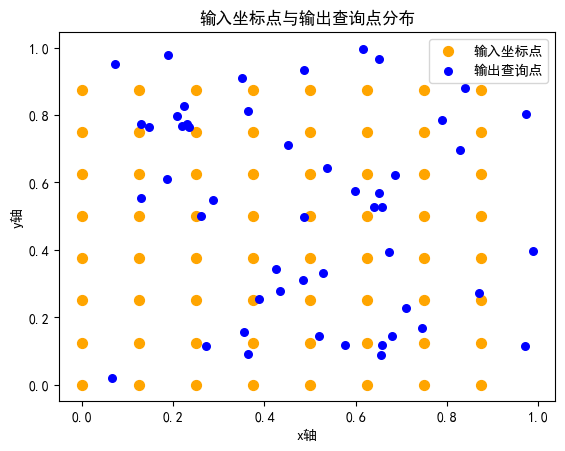

In [7]:
# 创建8x8的2D规则网格作为输入坐标
# regular_grid_2d生成(2, 8, 8)形状的张量（通道数，高度，宽度）
# permute(1, 2, 0)将维度转为(8, 8, 2)（高度，宽度，通道数）
# view(-1, 2)展平为(64, 2)的二维张量（共64个坐标点，每个点包含x/y两个维度）
input_coords = (
    torch.stack(regular_grid_2d(spatial_dims=(8, 8))).permute(1, 2, 0).view(-1, 2)
)

# 生成50个随机的输出查询点，每个点包含x/y两个维度，取值范围[0,1)
output_queries = torch.rand([50, 2])

plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

# 可视化输入坐标和查询点，直观展示数据分布
# 绘制输入坐标点：橙色，标记大小50，标签"Input coordinates"
plt.scatter(
    input_coords[:, 0],    # 所有输入点的x坐标
    input_coords[:, 1],    # 所有输入点的y坐标
    color="orange",        # 点的颜色
    label="输入坐标点",    # 图例标签（中文替换原英文）
    s=50,                  # 点的大小
)
# 绘制输出查询点：蓝色，标记大小30，标签"Output queries"
plt.scatter(
    output_queries[:, 0],  # 所有查询点的x坐标
    output_queries[:, 1],  # 所有查询点的y坐标
    color="blue",          # 点的颜色
    label="输出查询点",    # 图例标签
    s=30,                  # 点的大小
)
plt.legend(loc="upper right")    # 显示图例，并调整到右上角
plt.title("输入坐标点与输出查询点分布")  # 图表标题
plt.xlabel("x轴")          # x轴标签
plt.ylabel("y轴")          # y轴标签
plt.show()                # 显示图表




 ## 执行邻域搜索

 选择一个查询点，查找指定半径内的所有输入坐标点。 演示邻域搜索算法如何识别点云的空间关联关系。





In [8]:
# 选择第17个查询点（索引从0开始，16对应第17个）作为演示用例
query_index = 16
# 获取该查询点的坐标张量
query_point = output_queries[query_index]

# 执行半径为0.25的邻域搜索
# 注意：该半径相对于本示例的数据密度较大
# 实际应用中，通常选择能找到约10个邻域点的半径值
nbr_data = native_neighbor_search(
    data=input_coords,                # 待搜索的原始数据点集（输入坐标）
    queries=query_point.unsqueeze(0), # 待查询的点（增加维度适配函数输入要求）
    radius=0.25                       # 邻域搜索半径
)




 ## 可视化邻域搜索结果

 绘制查询点、其邻域点和搜索半径，直观理解邻域搜索算法的工作原理。





(0.0, 1.0)

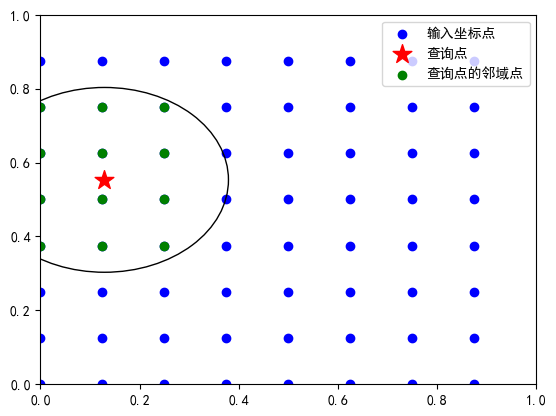

In [9]:
# 创建绘图画布和坐标轴对象
fig, ax = plt.subplots()
# 从输入坐标中提取查询点的邻域点（通过邻域搜索返回的索引）
neighbors = input_coords[nbr_data["neighbors_index"]]

# 绘制所有输入坐标点：蓝色，标签"输入坐标点"
ax.scatter(
    input_coords[:, 0], 
    input_coords[:, 1], 
    color="blue", 
    label="输入坐标点"
)
# 绘制选中的查询点：红色星型标记，大小200，标签"查询点"
ax.scatter(
    query_point[0],       # 查询点x坐标
    query_point[1],       # 查询点y坐标
    color="red",          # 颜色
    marker="*",           # 标记形状（星型）
    s=200,                # 标记大小
    label="查询点"
)
# 绘制查询点的邻域点：绿色，标签"查询点的邻域点"
ax.scatter(
    neighbors[:, 0],      # 邻域点x坐标
    neighbors[:, 1],      # 邻域点y坐标
    color="green",        # 颜色
    label="查询点的邻域点"
)
# 绘制查询点的搜索半径圆（空心），直观展示搜索范围
c = plt.Circle(query_point, radius=0.25, fill=False)
ax.add_patch(c)  # 将圆形添加到坐标轴

# 显示图例
ax.legend()
# 设置x轴范围（与点云坐标范围一致）
ax.set_xlim(0, 1)
# 设置y轴范围（与点云坐标范围一致）
ax.set_ylim(0, 1)